In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from scipy import stats
import toolbox
import xarray as xr
from cartopy.util import add_cyclic_point

def correlation_matrix_creator(predictors_and_target_df):
    predictors_and_target_df = predictors_and_target_df.to_numpy()
    corr_matrx = []
    for ts_1 in range(len(predictors_and_target_df.T)):
        corr_row = []
        for ts_2 in range(len(predictors_and_target_df.T)):

            timeseries_1 = predictors_and_target_df[:,ts_1]
            timeseries_2 = predictors_and_target_df[:,ts_2]
            
            N = len(timeseries_1)
            r = stats.pearsonr(timeseries_1[:], timeseries_2[:])[0]
            r1_autocorrelation = stats.pearsonr(timeseries_1[1:], timeseries_1[:-1])[0]
            r2_autocorrelation = stats.pearsonr(timeseries_2[1:], timeseries_2[:-1])[0]
            N_star = N*((1-r1_autocorrelation*r2_autocorrelation)/
                        (1+r1_autocorrelation*r2_autocorrelation))
            tcrit = stats.t.ppf(1-0.025, N_star)

            t = (r*np.sqrt(N_star - 2))/(np.sqrt(1 - r**2))

            if abs(t) - tcrit > 0:
                significant = 1
            else:
                significant = 0

            corr_row.append([r, significant])
        corr_matrx.append(corr_row)
    return np.array(corr_matrx)

def season_finder_profiles(calendar, m1, m2, m3,):
    """ 
    Data should be indexed as (years, months)
    """
    total_djf_anoms_list = [calendar[:,m1], calendar[:,m2], 
                            calendar[:,m3]]
    total_djf_anoms = np.swapaxes(total_djf_anoms_list, 0,1)
    shape = np.shape(total_djf_anoms)
    total_djf_timeseries = np.reshape(total_djf_anoms, (shape[0]*shape[1],shape[2], shape[3]))
    return(total_djf_timeseries)

def season_finder(calendar, m1, m2, m3):
    """ 
    Data should be indexed as (years, months)
    """
    total_djf_anoms_list = [calendar[:,m1], calendar[:,m2], 
                            calendar[:,m3]]
    total_djf_anoms = np.swapaxes(total_djf_anoms_list, 0,1)
    shape = np.shape(total_djf_anoms)
    total_djf_timeseries = np.reshape(total_djf_anoms, (shape[0]*shape[1]))
    return(total_djf_timeseries)

def season_finder_alts(calendar, m1, m2, m3):
    """ 
    Data should be indexed as (years, months)
    """
    total_djf_anoms_list = [calendar[:,m1], calendar[:,m2], 
                            calendar[:,m3]]
    total_djf_anoms = np.swapaxes(total_djf_anoms_list, 0,1)
    shape = np.shape(total_djf_anoms)
    total_djf_timeseries = np.reshape(total_djf_anoms, (shape[0]*shape[1], shape[2]))
    return(total_djf_timeseries)

def vw_star_winds(vw_star):
    vw_star_anoms = vw_star - np.nanmean(vw_star, axis=0)
    v_star_anoms = vw_star_anoms[:,:,:,0,:]
    w_star_anoms = vw_star_anoms[:,:,:,1,:]
    v_star_ts = np.reshape(v_star_anoms, (180,5,12))[5:]
    w_star_ts = np.reshape(w_star_anoms, (180,5,12))[5:]
    return(v_star_ts, w_star_ts)

def vw_winds(vw_tropics_5_degree):
    vw_tropics_5_degree = np.reshape(vw_tropics_5_degree, (2,15,12,5,12))
    v_winds = vw_tropics_5_degree[0]
    w_winds = vw_tropics_5_degree[1]
    v_anoms = v_winds - np.nanmean(v_winds, axis=0)
    v_anoms_ts = np.reshape(v_anoms, (180,5,12))
    w_anoms = w_winds - np.nanmean(w_winds, axis=0)
    w_anoms_ts = np.reshape(w_anoms, (180,5,12))
    v_anoms_ts = v_anoms_ts[5:,:,:]
    w_anoms_ts = w_anoms_ts[5:,:,:]
    return(v_anoms_ts, w_anoms_ts)

def cpt_alt_finder(temp_profs):
    calendar = []
    for yr in range(15):
        year_map = []
        for mon in range(12):
            month_map = []
            for lat in range(24):
                lat_line = []
                for lon in range(144):
                    try:
                        cpt_alt = np.nanargmin(temp_profs[yr,mon,lat,lon])/10 + 12
                    except:
                        cpt_alt = np.NaN
                    lat_line.append(cpt_alt)
                month_map.append(lat_line)
            year_map.append(month_map)
        calendar.append(year_map)
    calendar = np.array(calendar)
    return(calendar)

def correlator(pc, tmap):
    r_map = []
    sig_map = []
    for x in range(24):
        r_x = []
        sig_x = []
        for y in range(75):
            temp_series = tmap[:,x,y]
            pc = pc/np.nanstd(pc)
            try:
                N = len(temp_series)
                r = stats.pearsonr(temp_series[:], pc[:])[0]
                r1_autocorrelation = stats.pearsonr(temp_series[1:], temp_series[:-1])[0]
                r2_autocorrelation = stats.pearsonr(pc[1:], pc[:-1])[0]
                N_star = N*((1-r1_autocorrelation*r2_autocorrelation)/
                            (1+r1_autocorrelation*r2_autocorrelation))
                tcrit = stats.t.ppf(1-0.025, N_star)
                t = (r*np.sqrt(N_star - 2))/(np.sqrt(1 - r**2))
                if abs(t) - tcrit > 0:
                    significant = 1
                else:
                    significant = 0
            except:
                r = np.NaN
                significant = 0
            r_x.append(r)
            sig_x.append(significant)
        r_map.append(r_x)
        sig_map.append(sig_x)
    return(np.transpose(r_map), np.transpose(sig_map))

def regressor(pc, tmap):
    r_map = []
    for x in range(24):
        r_x = []
        for y in range(75):
            temp_series = tmap[:,x,y]
            try:
                r = stats.linregress(pc[:], temp_series)[0]
            except:
                r = np.NaN
            r_x.append(r)
        r_map.append(r_x)
    return(np.transpose(r_map))

def correlator_wv(pc, tmap):
    r_map = []
    sig_map = []
    for x in range(17):
        r_x = []
        sig_x = []
        for y in range(14):
            temp_series = tmap[:,x,y]
            pc = pc/np.nanstd(pc)
            N = len(temp_series)
            r = stats.pearsonr(temp_series[:], pc[:])[0]
            r1_autocorrelation = stats.pearsonr(temp_series[1:], temp_series[:-1])[0]
            r2_autocorrelation = stats.pearsonr(pc[1:], pc[:-1])[0]
            N_star = N*((1-r1_autocorrelation*r2_autocorrelation)/
                        (1+r1_autocorrelation*r2_autocorrelation))
            tcrit = stats.t.ppf(1-0.025, N_star)
            t = (r*np.sqrt(N_star - 2))/(np.sqrt(1 - r**2))
            if abs(t) - tcrit > 0:
                significant = 1
            else:
                significant = 0
            r_x.append(r)
            sig_x.append(significant)
        r_map.append(r_x)
        sig_map.append(sig_x)
    return(np.transpose(r_map), np.transpose(sig_map))

def regressor_wv(pc, tmap):
    r_map = []
    for x in range(17):
        r_x = []
        for y in range(14):
            temp_series = tmap[:,x,y]
            r = stats.linregress(pc[:], temp_series[:])[0]
            r_x.append(r)
        r_map.append(r_x)
    return(np.transpose(r_map))

def regressor_winds(pc, tmap):
    r_map = []
    for x in range(12):
        r_x = []
        for y in range(0,5):
            try:
                temp_series = tmap[:,y,x]
                pc = pc/np.nanstd(pc)
                correlation = stats.linregress(pc, temp_series)[0]
            except:
                correlation = np.NaN
                
            r_x.append(correlation)
        r_map.append(r_x)
    return(np.transpose(r_map))

def regression_ts(pc, tmap):    
    x_indices = np.shape(tmap)[1]
    y_indices = np.shape(tmap)[2]
    
    
    r_map = []
    for x in range(x_indices):
        r_x = []
        for y in range(y_indices):
            temp_series = tmap[:,x,y]
            temp_series_no_nan = temp_series[~np.isnan(temp_series)]
            pc_no_nan = pc[~np.isnan(temp_series)]
            try:
                reg = stats.linregress(pc_no_nan, temp_series_no_nan)
                reg_ts = reg[1] + reg[0]*pc
                
            except:
                reg_ts = np.repeat(np.NaN, len(temp_series))
            r_x.append(reg_ts)
        r_map.append(r_x)
    r_map = np.transpose(r_map)
    return(np.swapaxes(r_map, 1,2))

def regression_ts_allcf(pc, tmap):
    r_map = []
    for x in range(24):
        r_x = []
        for y in range(221):
            temp_series = tmap[:,x,y]
            try:
                reg = stats.linregress(pc, temp_series)
                reg_ts = reg[1] + reg[0]*pc
                
            except:
                reg_ts = np.repeat(np.NaN, len*temp_series)
            r_x.append(reg_ts)
        r_map.append(r_x)
    r_map = np.transpose(r_map)
    return(np.swapaxes(r_map, 1,2))

def regression_ts_prof(pc, tmap):
    y_indices = np.shape(tmap)[1]
    r_map = []
    for y in range(0, y_indices):
        temp_series = tmap[:,y]
        temp_series_no_nan = temp_series[~np.isnan(temp_series)]
        pc_no_nan = pc[~np.isnan(temp_series)]
        try:
            reg = stats.linregress(pc_no_nan, temp_series_no_nan)
            reg_ts = reg[1] + reg[0]*pc_no_nan
        except:
            reg_ts = np.repeat(np.NaN, len(temp_series_no_nan))
        r_map.append(reg_ts)
    r_mapT = np.transpose(r_map)
    size_of_nanarray  = 45 - len(r_mapT)
    nan_map = r_mapT[:size_of_nanarray]
    nan_map[:] = np.NaN
    r_mapT = np.concatenate((nan_map, r_mapT), axis=0)
    return(r_mapT)


In [5]:
# Pull in all timeseries
cpts, total_cf, temp_profs, profiles_cf, zonal_wind, mjo_index, enso_index, bdc_index, qbo_index = toolbox.starter()
project_path = '/home/disk/p/aodhan/cf_physical_parameters_correlations'

# also get the vertical temperature gradient
vert_temp_grad_profs = toolbox.vert_temp_gradient(temp_profs)

# Find the anomalies to all calendars
cpts_anomalies = toolbox.anomaly_finder(cpts)
temp_anomalies = toolbox.anomaly_finder(temp_profs)
vert_tempGrad_anomalies = toolbox.anomaly_finder(vert_temp_grad_profs)
vert_tanomGrad_anomalies = toolbox.vert_temp_gradient(temp_anomalies)
total_cf_anomalies = toolbox.anomaly_finder(total_cf)
profile_cf_anomalies = toolbox.anomaly_finder(profiles_cf)

# Find the average from S to N
cpt_tropical_mean = toolbox.tropical_average(cpts_anomalies)
temps_tropical_mean = toolbox.tropical_average(temp_anomalies)
vert_tempGrad_tropical_mean = toolbox.tropical_average(vert_tempGrad_anomalies)
vert_tanomGrad_tropical_mean = toolbox.tropical_average(vert_tanomGrad_anomalies)
total_cf_tropical_mean = toolbox.tropical_average(total_cf_anomalies[:,:,:,:])
profile_cf_tropical_mean = toolbox.tropical_average(profile_cf_anomalies)

# Get CP Tropopause altitudes
cpt_alts = cpt_alt_finder(np.array(temp_profs))
cpt_alts_zm = np.nanmean(cpt_alts, axis=3)
cpt_alts_zm_pres = np.load(project_path + '/tempmaps/calendar_of_cpt_pressures_zm.npy')


/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice


In [7]:
ttl_cloud_profiles = profiles_cf[:,:,:,:,25:-1]
ttl_cloud_profile_anoms = ttl_cloud_profiles - np.nanmean(ttl_cloud_profiles, axis=0)
ttl_cloud_profiles_zm_anoms = np.nanmean(ttl_cloud_profile_anoms, axis=3)
dt_dz_anomalies = vert_tempGrad_anomalies[:,:,:,:,:]
temp_profile_anoms_ts = np.reshape(temp_anomalies, (180,24,144,100))
temp_profile_anoms_ts_zm = np.nanmean(temp_profile_anoms_ts, axis=2)
temp_profile_anoms_ts_ = temp_profile_anoms_ts_zm
temp_profile_anoms_calendar = np.reshape(temp_profile_anoms_ts_, (15,12,24,100))
ttl_cloud_ts = np.reshape(ttl_cloud_profile_anoms, (180,24,144,75))
ttl_cloud_ts_zm = np.nanmean(ttl_cloud_ts, axis=2)[:]
ttl_cloud_calendar_zm = np.reshape(ttl_cloud_ts_zm, (15,12,24,75))
dtdz_profile_anoms_ts = np.reshape(dt_dz_anomalies, (180,24,144,100))
dtdz_profile_anoms_ts_zm = np.nanmean(dtdz_profile_anoms_ts, axis=2)
dtdz_profile_anoms_ts_ = dtdz_profile_anoms_ts_zm
dtdz_profile_anoms_calendar = np.reshape(dtdz_profile_anoms_ts_, (15,12,24,100))
zonal_wind_shear = zonal_wind[:,:,:,:,:]
zonal_wind_anoms = zonal_wind_shear - np.nanmean(zonal_wind_shear, axis=0)
zonal_wind_anoms = zonal_wind_anoms[:,:,:,:,:75]
zonal_wind_anoms_ts = np.reshape(zonal_wind_anoms, (180,24,144,75))
zonal_wind_anoms_ts_zm = np.nanmean(zonal_wind_anoms_ts, axis=2)
zonal_wind_anoms_ts_ = zonal_wind_anoms_ts_zm
zonal_wind_anoms_calendar = np.reshape(zonal_wind_anoms_ts_, (15,12,24,75))

/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]


In [8]:
# Depending on Cloud Fraction index, toggle this
def cf_profile_finder(cf_prof_maps):
    cf_prof_maps_ = np.sort(cf_prof_maps)
    profile_cf = np.array([np.load(cf_prof_maps_[yr])[0] for yr in range(len(cf_prof_maps_))])
    empty_prof_map = np.empty(np.shape(profile_cf[:5]))
    empty_prof_map[:] = np.NaN
    profile_cf = np.concatenate((empty_prof_map, profile_cf), axis=0)
    profile_cf = np.reshape(profile_cf, (15,12,24,144,221))
    profile_cf[10,1] = np.nanmean([profile_cf[10,0], profile_cf[10,2]], axis=0)
    profile_cf_anoms = profile_cf - np.nanmean(profile_cf, axis=0)
    profile_cf_anoms_zm = np.nanmean(profile_cf_anoms, axis=3)
    return(profile_cf_anoms_zm)

all_cf_prof_maps= glob.glob(project_path + '/aerosol_cloud_distinctions/cfmaps/ALLcfMonthlyProfiles_strataerosolremoved_1*.npy')
opaque_cf_prof_maps = glob.glob('/home/bdc/aodhan/CFmaps/TTLcfMonthlyProfiles_strataerosolremoved_*opaque.npy')
transparent_cf_prof_maps = glob.glob('/home/bdc/aodhan/CFmaps/TTLcfMonthlyProfiles_strataerosolremoved_*_transparent_noTTLcirrus.npy')

profile_all_cf_anoms_zm = cf_profile_finder(all_cf_prof_maps)
profile_transparent_anoms_zm = cf_profile_finder(transparent_cf_prof_maps)
profile_opaque_anoms_zm = cf_profile_finder(opaque_cf_prof_maps)



/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()


In [48]:
def get_eq_mean(calendar):
    eq_mean_calendar = np.nanmean(calendar[:,8:16,:], axis=1)    
    return(eq_mean_calendar)

def alt2pres(altitude):
    H = 7 
    press = 1000*np.exp(-1*(altitude/H))
    return press
def press2alt(press):
    H = 7 
    altitude = -1*H*np.log(press/1000)
    return altitude

def difference_and_significance_map(qbo_season, variable_eq_season):
    w_variable_season = variable_eq_season[qbo_season > 0.5]
    e_variable_season = variable_eq_season[qbo_season < -0.5]
    w_m_e_season = np.nanmean(w_variable_season, axis=0) - np.nanmean(e_variable_season, axis=0)
    w_season = np.nanmean(w_variable_season, axis=0)
    e_season = np.nanmean(e_variable_season, axis=0)
    difference_distribution = []
    w_distribution = []
    e_distribution = []
    for boot_strap_idx in range(1000):
        rand_indices_w = np.random.randint(low=0, high=len(w_variable_season), size=len(w_variable_season))
        random_w_cf_seasons = w_variable_season[rand_indices_w]
        w_distribution.append(np.nanmean(random_w_cf_seasons, axis=0))
        rand_indices_e = np.random.randint(low=0, high=len(e_variable_season), size=len(e_variable_season))
        random_e_cf_seasons = e_variable_season[rand_indices_e]
        e_distribution.append(np.nanmean(random_e_cf_seasons, axis=0))
        random_difference = np.nanmean(random_w_cf_seasons, axis=0) - np.nanmean(random_e_cf_seasons, axis=0)
        difference_distribution.append(random_difference)
    two_sigma_significance = np.nanstd(difference_distribution, axis=0)*2
    two_sigma_w_significance = np.nanstd(w_distribution, axis=0)*2
    two_sigma_e_significance = np.nanstd(e_distribution, axis=0)*2
    return(w_m_e_season, two_sigma_significance, w_season, 
           two_sigma_w_significance, e_season, two_sigma_e_significance)


def three_month_smoother(temp_profile_anoms_cal_west):    
        
    smoothed_west_anoms_DJF = [temp_profile_anoms_cal_west[:,11], temp_profile_anoms_cal_west[:,0], temp_profile_anoms_cal_west[:,1]]
    smoothed_west_anoms_JFM = [temp_profile_anoms_cal_west[:,0], temp_profile_anoms_cal_west[:,1], temp_profile_anoms_cal_west[:,2]]
    smoothed_west_anoms_FMA = [temp_profile_anoms_cal_west[:,1], temp_profile_anoms_cal_west[:,2], temp_profile_anoms_cal_west[:,3]]
    smoothed_west_anoms_MAM = [temp_profile_anoms_cal_west[:,2], temp_profile_anoms_cal_west[:,3], temp_profile_anoms_cal_west[:,4]]
    smoothed_west_anoms_AMJ = [temp_profile_anoms_cal_west[:,3], temp_profile_anoms_cal_west[:,4], temp_profile_anoms_cal_west[:,5]]
    smoothed_west_anoms_MJJ = [temp_profile_anoms_cal_west[:,4], temp_profile_anoms_cal_west[:,5], temp_profile_anoms_cal_west[:,6]]
    smoothed_west_anoms_JJA = [temp_profile_anoms_cal_west[:,5], temp_profile_anoms_cal_west[:,6], temp_profile_anoms_cal_west[:,7]]
    smoothed_west_anoms_JAS = [temp_profile_anoms_cal_west[:,6], temp_profile_anoms_cal_west[:,7], temp_profile_anoms_cal_west[:,8]]
    smoothed_west_anoms_ASO = [temp_profile_anoms_cal_west[:,7], temp_profile_anoms_cal_west[:,8], temp_profile_anoms_cal_west[:,9]]
    smoothed_west_anoms_SON = [temp_profile_anoms_cal_west[:,8], temp_profile_anoms_cal_west[:,9], temp_profile_anoms_cal_west[:,10]]
    smoothed_west_anoms_OND = [temp_profile_anoms_cal_west[:,9], temp_profile_anoms_cal_west[:,10], temp_profile_anoms_cal_west[:,11]]
    smoothed_west_anoms_NDJ = [temp_profile_anoms_cal_west[:,10], temp_profile_anoms_cal_west[:,11], temp_profile_anoms_cal_west[:,0]]

    smoothed_temp_profile_anoms_cal_west = [smoothed_west_anoms_DJF, smoothed_west_anoms_JFM,
                                            smoothed_west_anoms_FMA, smoothed_west_anoms_MAM,
                                            smoothed_west_anoms_AMJ, smoothed_west_anoms_MJJ,
                                            smoothed_west_anoms_JJA, smoothed_west_anoms_JAS,
                                            smoothed_west_anoms_ASO, smoothed_west_anoms_SON,
                                            smoothed_west_anoms_OND, smoothed_west_anoms_NDJ]
    
    smoothed_temp_profile_anoms_cal_west_ = np.nanmean(smoothed_temp_profile_anoms_cal_west, axis=1)
    smoothed_temp_profile_anoms_cal_west_ = np.nanmean(smoothed_temp_profile_anoms_cal_west_, axis=1)
    smoothed_temp_profile_anoms_cal_west_ = np.insert(smoothed_temp_profile_anoms_cal_west_, 12, smoothed_temp_profile_anoms_cal_west_[0])
    return(smoothed_temp_profile_anoms_cal_west_)

def lead_impact_finder(qbo_file, data_calendar):
    data_roladex = []
    for lead in range(5):
        lead_data = []
        if lead == 0:
            qbo_index = np.load(qbo_file)
            qbo = qbo_index - np.nanmean(qbo_index)
            qbo_index = qbo/np.nanstd(qbo)
            qbo_index = qbo_index[-180:]
        else:
            start = -180 - lead
            end = -1*lead
            qbo_index = np.load(qbo_file)
            qbo = qbo_index - np.nanmean(qbo_index)
            qbo_index = qbo/np.nanstd(qbo)
            qbo_index = qbo_index[start:end]
        for idx, season in enumerate(seasons):
            data_season = season_finder_profiles(data_calendar, season[0], season[1], season[2])[:]
            qbo_season = season_finder(np.reshape(qbo_index, (15,12)), season[0], season[1], season[2])[:]
            data_eq_season = get_eq_mean(data_season)

            ########### if you want to remove ENSO 3.4 signal, uncomment these lines ###########
            enso_season = season_finder(np.reshape(enso_index, (15,12)), season[0], season[1], season[2])
            data_eq_season = data_eq_season - regression_ts_prof(enso_season, data_eq_season)
            
            #dtdz_season = dtdz_season - regression_ts(enso_season, dtdz_season)
            #allcf_season = allcf_season - regression_ts(enso_season, allcf_season)
            #u_season = u_season - regression_ts(enso_season, u_season)        
            data_WmE_composite = difference_and_significance_map(qbo_season, data_eq_season)
            lead_data.append(data_WmE_composite)
        
        data_roladex.append(lead_data)
    
    data_roladex = np.array(data_roladex)
    return data_roladex


seasons = [[11,0,1], [0,1,2], [1,2,3], [2,3,4], [3,4,5], [4,5,6], [5,6,7],
           [6,7,8], [7,8,9], [8,9,10], [9,10,11], [10,11,0]]
qbo_file = project_path + '/statistics/u50.npy'
qbo_file = '/home/disk/p/aodhan/large_scale_dynamics/Monthly_ERSSTv5_Niño_3p4_1979_2020.npy'
enso_index = np.load('/home/disk/p/aodhan/large_scale_dynamics/Monthly_ERSSTv5_Niño_3p4_1979_2020.npy')[-180:]

cirrus_roladex = lead_impact_finder(qbo_file, ttl_cloud_calendar_zm)
#temp_roladex = lead_impact_finder(qbo_file, temp_profile_anoms_calendar)
#dtdz_roladex = lead_impact_finder(qbo_file, dtdz_profile_anoms_calendar)
allcf_roladex = lead_impact_finder(qbo_file, profile_all_cf_anoms_zm)
#u_roladex = lead_impact_finder(qbo_file, zonal_wind_anoms_calendar)
transparent_roladex = lead_impact_finder(qbo_file, profile_transparent_anoms_zm)
opaque_roladex = lead_impact_finder(qbo_file, profile_opaque_anoms_zm)

cpt_alts_zm = np.nanmean(np.reshape(cpt_alts[:,:,10:14,:], (15,12,4*144)), axis=2)
cpt_pres_zm = np.nanmean(cpt_alts_zm_pres, axis=2)
cpt_alt_smoothed = three_month_smoother(cpt_alts_zm)
cpt_pres_smoothed = three_month_smoother(cpt_pres_zm)


/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:117: RuntimeWarning: Mean of empty slice
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:118: RuntimeWarning: Mean of empty slice
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice


/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:153: UserWarning: No contour levels were found within the data range.


Text(-36.75, 0.0025, 'Opaque Clouds')

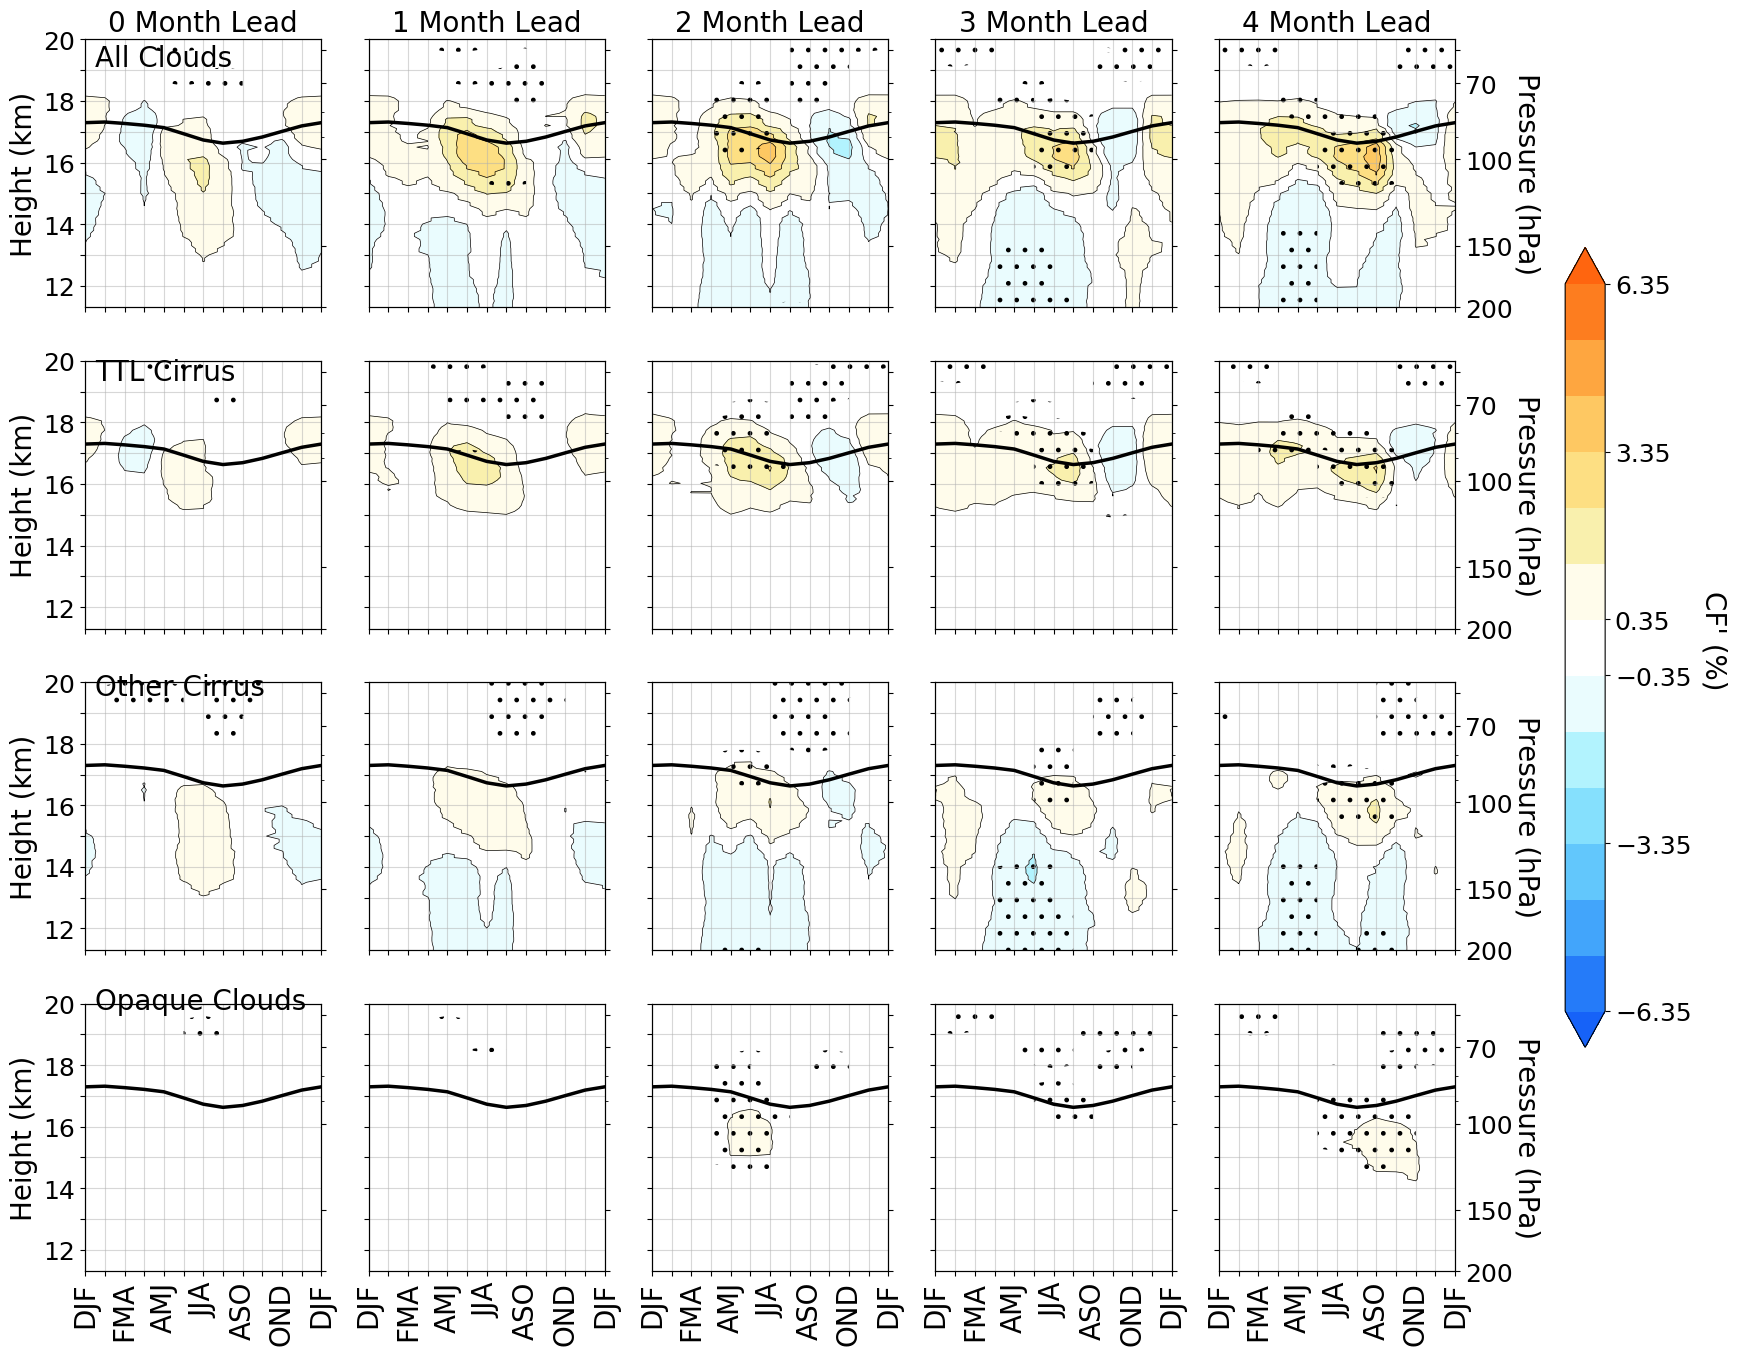

In [49]:
from matplotlib.colors import LinearSegmentedColormap

colors = np.array([(22,98,248), (48,141,250), (71,172,251), (100,201,252), (129,222,253),(162,240,254), (215,249,253), (255,255,255), 
                   (255,255,255), (255,249,217), (247,236,155), (254,221,128), (254,202,100), (255,173,71), (252,142,42), (255,101,15)])/255

custom_cmap = LinearSegmentedColormap.from_list('cmap', colors)

fig, axs = plt.subplots(4,5,figsize=(20,16))
season_names = ['DJF', ' ', 'FMA', ' ', 'AMJ',' ','JJA',' ', 'ASO',' ','OND',' ', 'DJF']

levels_cf = np.array([-6.35,-5.35,-4.35,-3.35,-2.35,-1.35,-.35,.35,1.35,2.35,3.35,4.35,5.35,6.35])

x_ticks = np.array([0,1,2,3,4,5,6,7,8,9,10,11])
for lead in range(5):
    axs[0,lead].set_title(str(lead) + ' Month Lead', fontsize=20)
    for var in range(4):
        if var == 0:
            allcf_cal = allcf_roladex[lead,:,0]
            sig_cal = abs(allcf_cal) - allcf_roladex[lead,:,1]
            sig_cal = sig_cal > 0
            cyclic_cal_sig, mon = add_cyclic_point(sig_cal.T, coord=x_ticks)
            allcf_heights = np.linspace(0,22,221)
            allcf_press = alt2pres(allcf_heights)
            cyclic_cal, mon = add_cyclic_point(allcf_cal.T, coord=x_ticks)
            allcf_im = axs[var,lead].contourf(mon, allcf_heights, cyclic_cal*100, levels=levels_cf, cmap=custom_cmap, extend='both')
            naned_cyclic_cal = cyclic_cal.copy()
            naned_cyclic_cal[:] = np.NaN
            ax2 = axs[var,lead].twinx()
            ax2.set_ylim(ax2.get_ylim()[::-1])
            ax2.set_yscale('log')
            ax2.contourf(mon, allcf_press, naned_cyclic_cal)
            axs[var,lead].contourf(mon, allcf_heights, cyclic_cal_sig, levels=[-1, 0, 1], 
                                   colors='none', hatches=[None,'.'])
            axs[var,lead].contour(mon, allcf_heights, cyclic_cal*100, levels=levels_cf, colors='black', linewidths=0.5, 
                                  linestyles=np.where(levels_cf >= 0, "-", "-"))
            axs[var,lead].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12])
            axs[var,lead].set_xticklabels(labels=[])
            axs[var,lead].set_yticks([11,12,13,14,15,16,17,18,19,20])
            ax2.set_yticks([200, 150, 100, 70, 60])
            if lead == 0:
                axs[var,lead].set_yticklabels(labels=[' ','12',' ','14',' ','16',' ','18',' ','20'], fontsize=18)
                ax2.set_yticklabels(labels=[' ',' ',' ',' ', ' '], fontsize=18)
                axs[var,lead].set_ylabel("Height (km)", fontsize=20)
            elif lead == 4:
                axs[var,lead].set_yticklabels(labels=[' ',' ',' ',' ',' ',' ',' ',' ',' ',' '], fontsize=18)
                ax2.set_yticklabels(labels=['200','150','100','70', ' '], fontsize=18)
                ax2.set_ylabel("Pressure (hPa)", fontsize=20, rotation=270, labelpad=20)
            else:
                axs[var,lead].set_yticklabels(labels=[' ',' ',' ',' ',' ',' ',' ',' ',' ',' '], fontsize=18)
                ax2.set_yticklabels(labels=[' ',' ',' ',' ', ' '], fontsize=18)
            ax2.set_ylim(200,57)
            axs[var,lead].set_ylim(11.3,20)
            #axs[var,lead].set_ylim(0,20)
            axs[var,lead].plot(cpt_alt_smoothed, color='black', linewidth=2.5)
                
        if var == 1:
            ttl_cirrus_cal = cirrus_roladex[lead,:,0]
            sig_cal = abs(ttl_cirrus_cal) - cirrus_roladex[lead,:,1]
            sig_cal = sig_cal > 0
            cyclic_cal_sig, mon = add_cyclic_point(sig_cal.T, coord=x_ticks)
            cf_heights = np.linspace(14.5,22,75)
            cf_press = alt2pres(cf_heights)
            cyclic_cal, mon = add_cyclic_point(ttl_cirrus_cal.T, coord=x_ticks)
            allcf_im = axs[var,lead].contourf(mon, cf_heights, cyclic_cal*100, levels=levels_cf, cmap=custom_cmap, extend='both')
            naned_cyclic_cal = cyclic_cal.copy()
            naned_cyclic_cal[:] = np.NaN
            ax2 = axs[var,lead].twinx()
            ax2.set_ylim(ax2.get_ylim()[::-1])
            ax2.set_yscale('log')
            ax2.contourf(mon, cf_press, naned_cyclic_cal)
            axs[var,lead].contourf(mon, cf_heights, cyclic_cal_sig, levels=[-1, 0, 1], 
                                   colors='none', hatches=[None,'.'])
            axs[var,lead].contour(mon, cf_heights, cyclic_cal*100, levels=levels_cf, colors='black', linewidths=0.5, 
                                  linestyles=np.where(levels_cf >= 0, "-", "-"))
            axs[var,lead].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12])
            axs[var,lead].set_xticklabels(labels=[])
            axs[var,lead].set_yticks([11,12,13,14,15,16,17,18,19,20])
            ax2.set_yticks([200, 150, 100, 70, 60])
            if lead == 0:
                axs[var,lead].set_yticklabels(labels=[' ','12',' ','14',' ','16',' ','18',' ','20'], fontsize=18)
                ax2.set_yticklabels(labels=[' ',' ',' ',' ', ' '], fontsize=18)
                axs[var,lead].set_ylabel("Height (km)", fontsize=20)
            elif lead == 4:
                axs[var,lead].set_yticklabels(labels=[' ',' ',' ',' ',' ',' ',' ',' ',' ',' '], fontsize=18)
                ax2.set_yticklabels(labels=['200','150','100','70', ' '], fontsize=18)
                ax2.set_ylabel("Pressure (hPa)", fontsize=20, rotation=270, labelpad=20)
            else:
                axs[var,lead].set_yticklabels(labels=[' ',' ',' ',' ',' ',' ',' ',' ',' ',' '], fontsize=18)
                ax2.set_yticklabels(labels=[' ',' ',' ',' ', ' '], fontsize=18)
            axs[var,lead].set_ylim(11,20)
            ax2.set_ylim(200,57)
            axs[var,lead].set_ylim(11.3,20)
            #axs[var,lead].set_ylim(0,20)
            axs[var,lead].plot(cpt_alt_smoothed, color='black', linewidth=2.5)
            
        if var == 2:
            allcf_cal = transparent_roladex[lead,:,0]
            sig_cal = abs(allcf_cal) - transparent_roladex[lead,:,1]
            sig_cal = sig_cal > 0
            cyclic_cal_sig, mon = add_cyclic_point(sig_cal.T, coord=x_ticks)
            allcf_heights = np.linspace(0,22,221)
            allcf_press = alt2pres(allcf_heights)
            cyclic_cal, mon = add_cyclic_point(allcf_cal.T, coord=x_ticks)
            allcf_im = axs[var,lead].contourf(mon, allcf_heights, cyclic_cal*100, levels=levels_cf, cmap=custom_cmap, extend='both')
            naned_cyclic_cal = cyclic_cal.copy()
            naned_cyclic_cal[:] = np.NaN
            ax2 = axs[var,lead].twinx()
            ax2.set_ylim(ax2.get_ylim()[::-1])
            ax2.set_yscale('log')
            ax2.contourf(mon, allcf_press, naned_cyclic_cal)
            axs[var,lead].contourf(mon, allcf_heights, cyclic_cal_sig, levels=[-1, 0, 1], 
                                   colors='none', hatches=[None,'.'])
            axs[var,lead].contour(mon, allcf_heights, cyclic_cal*100, levels=levels_cf, colors='black', linewidths=0.5, 
                                  linestyles=np.where(levels_cf >= 0, "-", "-"))
            axs[var,lead].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12])
            axs[var,lead].set_xticklabels(labels=[])
            axs[var,lead].set_yticks([11,12,13,14,15,16,17,18,19,20])
            ax2.set_yticks([200, 150, 100, 70, 60])
            if lead == 0:
                axs[var,lead].set_yticklabels(labels=[' ','12',' ','14',' ','16',' ','18',' ','20'], fontsize=18)
                ax2.set_yticklabels(labels=[' ',' ',' ',' ', ' '], fontsize=18)
                axs[var,lead].set_ylabel("Height (km)", fontsize=20)
            elif lead == 4:
                axs[var,lead].set_yticklabels(labels=[' ',' ',' ',' ',' ',' ',' ',' ',' ',' '], fontsize=18)
                ax2.set_yticklabels(labels=['200','150','100','70', ' '], fontsize=18)
                ax2.set_ylabel("Pressure (hPa)", fontsize=20, rotation=270, labelpad=20)
            else:
                axs[var,lead].set_yticklabels(labels=[' ',' ',' ',' ',' ',' ',' ',' ',' ',' '], fontsize=18)
                ax2.set_yticklabels(labels=[' ',' ',' ',' ', ' '], fontsize=18)
            axs[var,lead].set_ylim(11,20)
            ax2.set_ylim(200,57)
            axs[var,lead].set_ylim(11.3,20)
            #axs[var,lead].set_ylim(0,20)
            axs[var,lead].plot(cpt_alt_smoothed, color='black', linewidth=2.5)
        if var == 3:
            allcf_cal = opaque_roladex[lead,:,0]
            sig_cal = abs(allcf_cal) - opaque_roladex[lead,:,1]
            sig_cal = sig_cal > 0
            cyclic_cal_sig, mon = add_cyclic_point(sig_cal.T, coord=x_ticks)
            allcf_heights = np.linspace(0,22,221)
            allcf_press = alt2pres(allcf_heights)
            cyclic_cal, mon = add_cyclic_point(allcf_cal.T, coord=x_ticks)
            allcf_im = axs[var,lead].contourf(mon, allcf_heights, cyclic_cal*100, levels=levels_cf, cmap=custom_cmap, extend='both')
            naned_cyclic_cal = cyclic_cal.copy()
            naned_cyclic_cal[:] = np.NaN
            ax2 = axs[var,lead].twinx()
            ax2.set_ylim(ax2.get_ylim()[::-1])
            ax2.set_yscale('log')
            ax2.contourf(mon, allcf_press, naned_cyclic_cal)
            axs[var,lead].contourf(mon, allcf_heights, cyclic_cal_sig, levels=[-1, 0, 1], 
                                   colors='none', hatches=[None,'.'])
            axs[var,lead].contour(mon, allcf_heights, cyclic_cal*100, levels=levels_cf, colors='black', linewidths=0.5, 
                                  linestyles=np.where(levels_cf >= 0, "-", "-"))
            axs[var,lead].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12])
            axs[var,lead].set_xticklabels(labels=[])
            axs[var,lead].set_yticks([11,12,13,14,15,16,17,18,19,20])
            ax2.set_yticks([200, 150, 100, 70, 60])
            if lead == 0:
                axs[var,lead].set_yticklabels(labels=[' ','12',' ','14',' ','16',' ','18',' ','20'], fontsize=18)
                ax2.set_yticklabels(labels=[' ',' ',' ',' ', ' '], fontsize=18)
                axs[var,lead].set_ylabel("Height (km)", fontsize=20)
            elif lead == 4:
                axs[var,lead].set_yticklabels(labels=[' ',' ',' ',' ',' ',' ',' ',' ',' ',' '], fontsize=18)
                ax2.set_yticklabels(labels=['200','150','100','70', ' '], fontsize=18)
                ax2.set_ylabel("Pressure (hPa)", fontsize=20, rotation=270, labelpad=20)
            else:
                axs[var,lead].set_yticklabels(labels=[' ',' ',' ',' ',' ',' ',' ',' ',' ',' '], fontsize=18)
                ax2.set_yticklabels(labels=[' ',' ',' ',' ', ' '], fontsize=18)
            ax2.set_ylim(200,57)
            axs[var,lead].set_ylim(11.3,20)
            #axs[var,lead].set_ylim(0,20)
            
            axs[var,lead].plot(cpt_alt_smoothed, color='black', linewidth=2.5)

        
for item in range(4): 
    for i in range(5):
        axs[item,i].grid(alpha=0.5)
        axs[3,i].set_xticklabels(labels=season_names, fontsize=20, rotation=90)

fig.subplots_adjust(right=0.81)

cbar_cf = fig.add_axes([0.865, 0.25, 0.02, 0.5])
fig.colorbar(allcf_im, cax=cbar_cf, orientation='vertical', ticks=[-6.35,-3.35,-.35,.35,3.35,6.35])
cbar_cf.tick_params(labelsize=18)
plt.text(3.35, 0.45, "CF' (%)", fontsize = 20, rotation=270)
plt.text(-36.75, 1.3, "All Clouds", fontsize = 20, rotation=0)
plt.text(-36.75, .8675, "TTL Cirrus", fontsize = 20, rotation=0)
plt.text(-36.75, .4350, "Other Cirrus", fontsize = 20, rotation=0)
plt.text(-36.75, .0025, "Opaque Clouds", fontsize = 20, rotation=0)

#plt.savefig('../figures/QBOE_CF_partitioning_4mo_leads.png', dpi=300)


NameError: name 'temp_roladex' is not defined

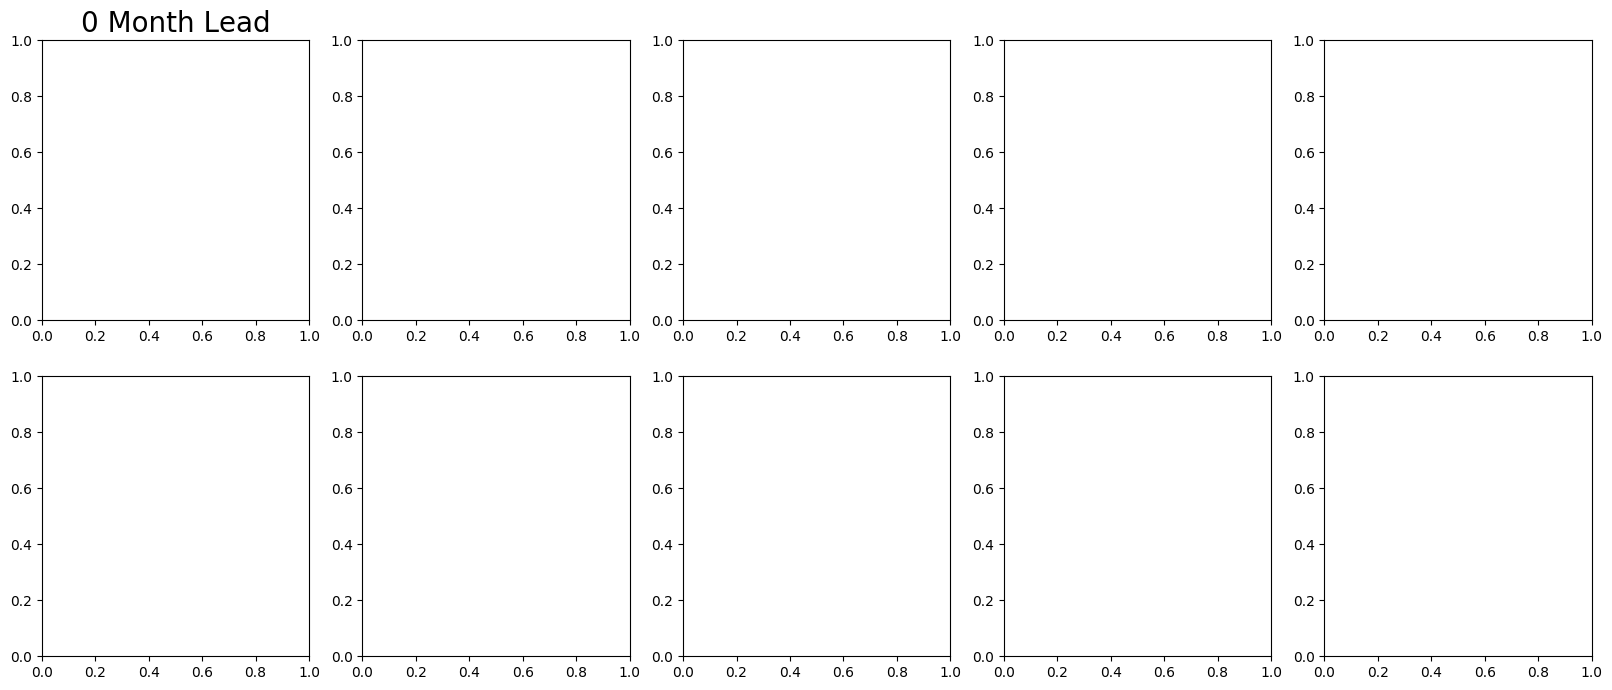

In [12]:
fig, axs = plt.subplots(2,5,figsize=(20,8))
season_names = ['DJF', ' ', 'FMA', ' ', 'AMJ',' ','JJA',' ', 'ASO',' ','OND',' ', 'DJF']

x_ticks = np.array([0,1,2,3,4,5,6,7,8,9,10,11])
for lead in range(5):
    axs[0,lead].set_title(str(lead) + ' Month Lead', fontsize=20)
    for var in range(2):
        if var == 0:
            temp_cal = temp_roladex[lead,:,0]
            sig_cal = abs(temp_cal) - temp_roladex[lead,:,1]
            sig_cal = sig_cal > 0
            cyclic_cal_sig, mon = add_cyclic_point(sig_cal.T, coord=x_ticks)
            temp_heights = np.linspace(12,22,100)
            temp_press = alt2pres(temp_heights)
            levels_temp = np.array([-4,-3.5,-3,-2.5,-2,-1.5,-1,-.5,.5,1,1.5,2,2.5,3,3.5,4])
            cyclic_cal, mon = add_cyclic_point(temp_cal.T, coord=x_ticks)
            temp_im = axs[var,lead].contourf(mon, temp_heights, cyclic_cal, levels=levels_temp, cmap=custom_cmap)
            naned_cyclic_cal = cyclic_cal.copy()
            naned_cyclic_cal[:] = np.NaN
            ax2 = axs[var,lead].twinx()
            ax2.set_ylim(ax2.get_ylim()[::-1])
            ax2.set_yscale('log')
            ax2.contourf(mon, temp_press, naned_cyclic_cal)
            axs[var,lead].contourf(mon, temp_heights, cyclic_cal_sig, levels=[-1, 0, 1], 
                                   colors='none', hatches=[None,'.'])
            axs[var,lead].contour(mon, temp_heights, cyclic_cal, levels=levels_temp, colors='black', linewidths=0.5, 
                                  linestyles=np.where(levels_temp >= 0, "-", "-"))
            axs[var,lead].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12])
            axs[var,lead].set_xticklabels(labels=[])
            axs[var,lead].set_yticks([11,12,13,14,15,16,17,18,19,20])
            ax2.set_yticks([200, 150, 100, 70, 60])
            if lead == 0:
                axs[var,lead].set_yticklabels(labels=[' ','12',' ','14',' ','16',' ','18',' ','20'], fontsize=18)
                ax2.set_yticklabels(labels=[' ',' ',' ',' ', ' '], fontsize=18)
                axs[var,lead].set_ylabel("Height (km)", fontsize=20)
            elif lead == 4:
                axs[var,lead].set_yticklabels(labels=[' ',' ',' ',' ',' ',' ',' ',' ',' ',' '], fontsize=18)
                ax2.set_yticklabels(labels=['200','150','100','70', ' '], fontsize=18)
                ax2.set_ylabel("Pressure (hPa)", fontsize=20, rotation=270, labelpad=20)
            else:
                axs[var,lead].set_yticklabels(labels=[' ',' ',' ',' ',' ',' ',' ',' ',' ',' '], fontsize=18)
                ax2.set_yticklabels(labels=[' ',' ',' ',' ', ' '], fontsize=18)
            axs[var,lead].set_ylim(11,20)
            ax2.set_ylim(200,57)
            axs[var,lead].set_ylim(11.3,20)
            axs[var,lead].plot(cpt_alt_smoothed, color='black')
            
                
        if var == 1:
            dtdz_cal = dtdz_roladex[lead,:,0]
            sig_cal = abs(dtdz_cal) - dtdz_roladex[lead,:,1]
            sig_cal = sig_cal > 0
            cyclic_cal_sig, mon = add_cyclic_point(sig_cal.T, coord=x_ticks)
            dtdz_heights = np.linspace(12,22,100)
            levels_dtdz = np.array([-1.5, -1.3, -1.1, -0.9, -0.7, -0.5, -0.3, 
                                    -0.1,0.1,0.3,0.5,0.7,0.9,1.1,1.3,1.5])
            #levels_dtdz = np.array([-9,-7.5,-6,-4.5,-3, -7.5,1.5,3,4.5,6,7.5,9])/100
            cyclic_cal, mon = add_cyclic_point(dtdz_cal.T, coord=x_ticks)
            dtdz_im = axs[var,lead].contourf(mon, dtdz_heights, cyclic_cal, levels=levels_dtdz, cmap=custom_cmap, extend='both')
            naned_cyclic_cal = cyclic_cal.copy()
            naned_cyclic_cal[:] = np.NaN
            axdtdz = axs[var,lead].twinx()
            axdtdz.set_ylim(axdtdz.get_ylim()[::-1])
            axdtdz.set_yscale('log')
            axdtdz.contourf(mon, temp_press, naned_cyclic_cal)
            axs[var,lead].contour(mon, dtdz_heights, cyclic_cal, levels=levels_dtdz, colors='black', 
                                  linewidths=0.5, 
                                  linestyles=np.where(levels_dtdz >= 0, "-", "-"))
            axs[var,lead].contourf(mon, dtdz_heights, cyclic_cal_sig, levels=[-1, 0, 1], 
                                   colors='none', hatches=[None,'.'])
            axs[var,lead].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12])
            axs[var,lead].set_xticklabels(labels=[])
            axs[var,lead].set_yticks([11,12,13,14,15,16,17,18,19,20])
            axdtdz.set_yticks([200, 150, 100, 70, 60])
            if lead == 0:
                axs[var,lead].set_yticklabels(labels=[' ','12',' ','14',' ','16',' ','18',' ','20'], fontsize=18)
                axdtdz.set_yticklabels(labels=[' ',' ',' ',' ', ' '], fontsize=18)
                axs[var,lead].set_ylabel("Height (km)", fontsize=20)
            elif lead == 4:
                axs[var,lead].set_yticklabels(labels=[' ',' ',' ',' ',' ',' ',' ',' ',' ',' '], fontsize=18)
                axdtdz.set_yticklabels(labels=['200','150','100','70', ' '], fontsize=18)
                axdtdz.set_ylabel("Pressure (hPa)", fontsize=20, rotation=270, labelpad=20)
            else:
                axs[var,lead].set_yticklabels(labels=[' ',' ',' ',' ',' ',' ',' ',' ',' ',' '], fontsize=18)
                axdtdz.set_yticklabels(labels=[' ',' ',' ',' ', ' '], fontsize=18)
            axs[var,lead].set_ylim(11,20)
            axdtdz.set_ylim(200,57)
            axs[var,lead].set_ylim(11.3,20)
            axs[var,lead].plot(cpt_alt_smoothed, color='black')

        
for item in range(2): 
    for i in range(5):
        axs[item,i].grid(alpha=0.5)
        axs[1,i].set_xticklabels(labels=season_names, fontsize=16, rotation=90)

fig.subplots_adjust(right=0.81)


cbar_temp = fig.add_axes([0.865, 0.5325, 0.02, 0.35])
fig.colorbar(temp_im, cax=cbar_temp, orientation='vertical', ticks=[-4,-2.5,-1,1,2.5,4])
cbar_temp.tick_params(labelsize=18)
plt.text(2.95, 0.375, "T' (K)", fontsize = 20, rotation=270)


cbar_dtdz = fig.add_axes([0.865, 0.12, 0.02, 0.35])
fig.colorbar(dtdz_im, cax=cbar_dtdz, orientation='vertical', 
             ticks=[-1.5, -0.9, -0.3, 0.3, 0.9, 1.5])
cbar_dtdz.tick_params(labelsize=18)
plt.text(2.95, 0.15, "dT'/dZ (K/km)", fontsize = 20, rotation=270)

#plt.savefig('../figures/T_dTdZ_4mo_leads.png', dpi=300)


Text(2.6, 0.25, "U' (m/s)")

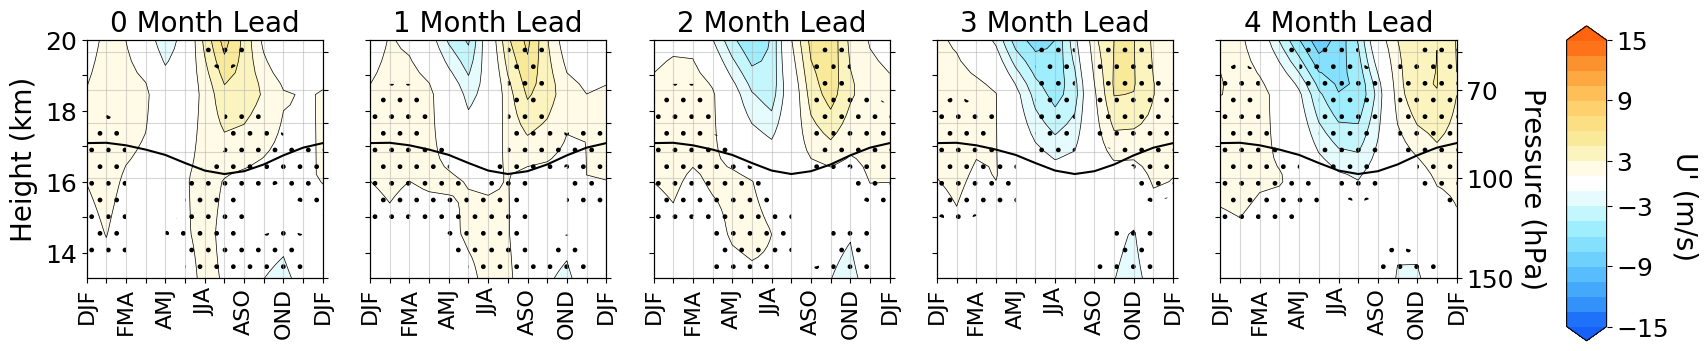

In [39]:
fig, axs = plt.subplots(1,5,figsize=(20,3.5))
season_names = ['DJF', ' ', 'FMA', ' ', 'AMJ',' ','JJA',' ', 'ASO',' ','OND',' ', 'DJF']
colors = np.array([(22,98,248), (48,141,250), (71,172,251), (100,201,252), (129,222,253),(162,240,254), (215,249,253), (255,255,255), 
                   (255,255,255), (255,249,217), (247,236,155), (254,221,128), (254,202,100), (255,173,71), (252,142,42), (255,101,15)])/255
x_ticks = np.array([0,1,2,3,4,5,6,7,8,9,10,11])
for lead in range(5):
    axs[lead].set_title(str(lead) + ' Month Lead', fontsize=20)
    u_cal = u_roladex[lead,:,0]
    sig_cal = abs(u_cal) - u_roladex[lead,:,1]
    sig_cal = sig_cal > 0
    cyclic_cal_sig, mon = add_cyclic_point(sig_cal.T, coord=x_ticks)
    u_pressures = np.linspace(50,350,100)[:75]
    alts = np.flip(press2alt(u_pressures))
    levels_u = np.array([-15,-13.5,-12,-10.5,-9,-7.5,-6,-4.5,-3,-1.5,1.5,3,4.5,6,7.5,9,10.5,12,13.5,15])
    cyclic_cal, mon = add_cyclic_point(u_cal.T, coord=x_ticks)
    naned_cyclic_cal = cyclic_cal.copy()
    naned_cyclic_cal[:] = np.NaN
    u_im = axs[lead].contourf(mon, u_pressures, cyclic_cal, levels=levels_u, cmap=custom_cmap, extend='both')
    ax2 = axs[lead].twinx()
    ax2.contourf(mon, alts, naned_cyclic_cal)
    axs[lead].contourf(mon, u_pressures, cyclic_cal_sig, levels=[-1, 0, 1], 
                           colors='none', hatches=[None,'.'])
    axs[lead].contour(mon, u_pressures, cyclic_cal, levels=levels_u, colors='black', linewidths=0.5, 
                          linestyles=np.where(levels_u >= 0, "-", "-"))
    axs[lead].plot(cpt_pres_smoothed, color='black')
    axs[lead].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12])
    axs[lead].set_xticklabels(labels=[])
    
    axs[lead].set_ylim(axs[lead].get_ylim()[::-1])
    axs[lead].yaxis.tick_right()
    ax2.yaxis.tick_left()
    axs[lead].set_yscale('log')
    axs[lead].set_yticks([150, 100, 90, 80, 70, 60])
    ax2.set_yticks([14,15,16,17,18,19, 20])

    if lead == 0:
        ax2.set_yticklabels(labels=['14',' ','16',' ','18',' ', '20'], fontsize=18)
        axs[lead].set_yticklabels(labels=[' ',' ',' ',' ', ' ', ' ', ' '], fontsize=18)
        axs[lead].set_ylabel("Height (km)", fontsize=20, labelpad=35)
    elif lead == 4:
        ax2.set_yticklabels(labels=[' ',' ',' ',' ',' ',' ',' ', ' '], fontsize=18)
        #ax2.yaxis.tick_right()
        axs[lead].set_yticklabels(labels=['150','100',' ',' ', '70', ' ', ' '], fontsize=18)
        #axs[i].set_ylabel("Pressure (hPa)", fontsize=20, rotation=270, labelpad=20)
    else:
        ax2.set_yticklabels(labels=[' ',' ',' ',' ',' ',' ',' ', ' '], fontsize=18)
        axs[lead].set_yticklabels(labels=[' ',' ',' ',' ', ' ', ' ', ' '], fontsize=18)
        

    axs[lead].plot(cpt_alt_smoothed, color='black')
    axs[lead].set_xticklabels(labels=season_names, fontsize=16, rotation=90)
    axs[lead].set_ylim(150, 57)
    ax2.set_ylim(13.3,20)
        
for i in range(5):
    axs[i].set_xticklabels(labels=season_names, fontsize=16, rotation=90)
    axs[i].grid(alpha=0.5)

fig.subplots_adjust(right=0.81)
fig.subplots_adjust(bottom=0.2)


cbar_u = fig.add_axes([0.865, 0.02, 0.02, 0.9])
fig.colorbar(u_im, cax=cbar_u, orientation='vertical', ticks=[-15,-9,-3,3,9,15])
cbar_u.tick_params(labelsize=18)
plt.text(-1.2, 0.15, "Pressure (hPa)", fontsize = 20, rotation=270)
plt.text(2.6, 0.25, "U' (m/s)", fontsize = 20, rotation=270)

#plt.savefig('../figures/U_4mo_leads.png', dpi=300)

In [16]:
qbo_file = '../statistics/u50.npy'
#qbo_file = '../fileCreators/u50_anoms_singapore.npy'

def composites_and_significance_ts(qbo_season, variable_eq_season):
    qbo_season = qbo_season - np.nanmean(qbo_season)
    qbo_season = qbo_season/np.nanstd(qbo_season)
    w_variable_season = variable_eq_season[qbo_season > .5]
    e_variable_season = variable_eq_season[qbo_season < -.5]
    w_season = np.nanmean(w_variable_season, axis=0)
    e_season = np.nanmean(e_variable_season, axis=0)
    w_m_e_season = w_season - e_season

    difference_distribution = []
    w_distribution = []
    e_distribution = []
    for boot_strap_idx in range(1000):
        rand_indices_w = np.random.randint(low=0, high=len(w_variable_season), size=len(w_variable_season))
        random_w_cf_seasons = w_variable_season[rand_indices_w]
        w_distribution.append(np.nanmean(random_w_cf_seasons))
        rand_indices_e = np.random.randint(low=0, high=len(e_variable_season), size=len(e_variable_season))
        random_e_cf_seasons = e_variable_season[rand_indices_e]
        e_distribution.append(np.nanmean(random_e_cf_seasons))
        random_difference = np.nanmean(random_w_cf_seasons, axis=0) - np.nanmean(random_e_cf_seasons, axis=0)
        difference_distribution.append(random_difference)
    two_sigma_difference_significance = np.nanstd(difference_distribution, axis=0)*2
    two_sigma_w_significance = np.nanstd(w_distribution, axis=0)*2
    two_sigma_e_significance = np.nanstd(e_distribution, axis=0)*2

    return(w_m_e_season, two_sigma_difference_significance, 
           w_season, two_sigma_w_significance, 
           e_season, two_sigma_e_significance)

sw_lw = xr.open_dataset('/home/bdc/aodhan/sw_lw_ceres.nc')
sw_cre_2006_2020 = sw_lw.toa_sw_clr_c_mon.values - sw_lw.toa_sw_all_mon.values
sw_cre_2006_2020 = sw_cre_2006_2020[70:-15]
sw_cre_2006_2020_calendar = np.reshape(sw_cre_2006_2020, (15,12,60,360))
sw_cre_2006_2020_anoms = sw_cre_2006_2020_calendar - np.nanmean(sw_cre_2006_2020_calendar, axis=0)
sw_cre_2006_2020_anoms_equatorial = sw_cre_2006_2020_anoms[:,:,20:40,:]
sw_cre_2006_2020_anoms_equatorial = np.nanmean(np.reshape(sw_cre_2006_2020_anoms_equatorial, (15,12, 20*360)), axis=2)
sw_cre_anoms_cal = sw_cre_2006_2020_anoms_equatorial

lw_cre_2006_2020 = sw_lw.toa_lw_clr_c_mon.values - sw_lw.toa_lw_all_mon.values
lw_cre_2006_2020 = lw_cre_2006_2020[70:-15]
lw_cre_2006_2020_calendar = np.reshape(lw_cre_2006_2020, (15,12,60,360))
lw_cre_2006_2020_anoms = lw_cre_2006_2020_calendar - np.nanmean(lw_cre_2006_2020_calendar, axis=0)
lw_cre_2006_2020_anoms_equatorial = lw_cre_2006_2020_anoms[:,:,20:40,:]
lw_cre_2006_2020_anoms_equatorial = np.nanmean(np.reshape(lw_cre_2006_2020_anoms_equatorial, (15,12, 20*360)), axis=2)
lw_cre_anoms_cal = lw_cre_2006_2020_anoms_equatorial


lw_roladex = []
sw_roladex = []
for i in range(12):
    one_lead_lw = []
    one_lead_sw = []
    if i == 0:
        qbo_index = np.load(qbo_file)
        #qbo = qbo_index - np.nanmean(qbo_index)
        #qbo_index = qbo/np.nanstd(qbo)
        qbo_index = qbo_index[-180:]
    else:
        start = -180 - i
        end = -1*i
        qbo_index = np.load(qbo_file)
        #qbo = qbo_index - np.nanmean(qbo_index)
        #qbo_index = qbo/np.nanstd(qbo)
        qbo_index = qbo_index[start:end]
    for idx, season in enumerate(seasons):
        name = season_names[idx]
        lw_season = season_finder(lw_cre_anoms_cal, season[0], season[1], season[2])[:]
        sw_season = season_finder(sw_cre_anoms_cal, season[0], season[1], season[2])[:]
        qbo_season = season_finder(np.reshape(qbo_index, (15,12)), season[0], season[1], season[2])[:]
        one_lead_lw.append(composites_and_significance_ts(qbo_season, lw_season))
        one_lead_sw.append(composites_and_significance_ts(qbo_season, sw_season))
    lw_roladex.append(one_lead_lw)
    sw_roladex.append(one_lead_sw)
lw_roladex = np.array(lw_roladex)
sw_roladex = np.array(sw_roladex)


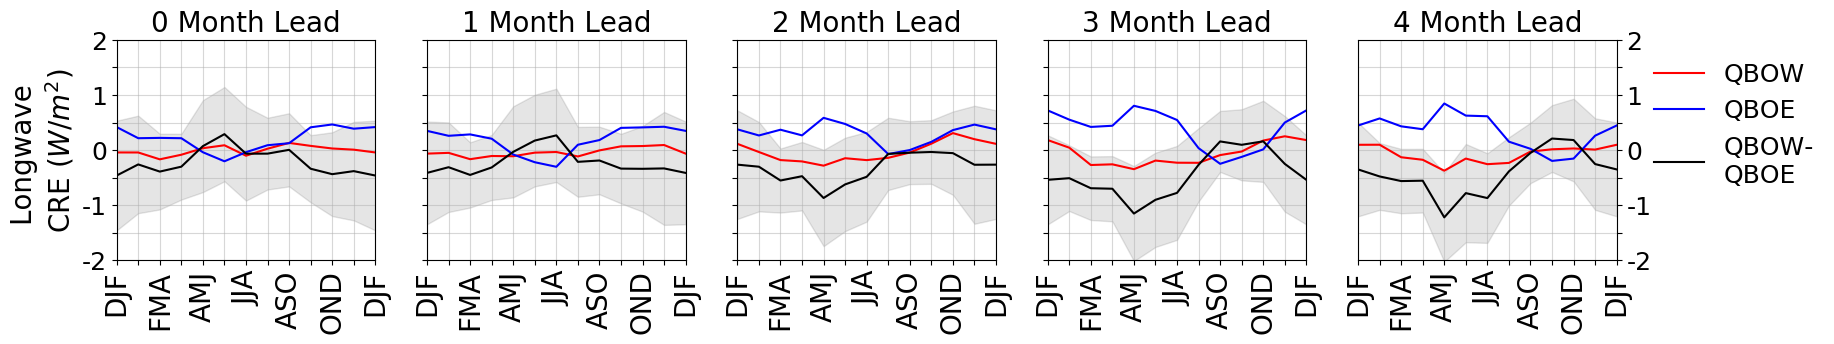

In [17]:
from cartopy.util import add_cyclic_point
months = np.arange(1,13,1)
season_names = ['DJF', ' ', 'FMA', ' ', 'AMJ',' ', 'JJA',' ', 'ASO',' ','OND',' ', 'DJF']
fig, axs = plt.subplots(1,5, figsize=(20,3.5))
for i in range(0, 5):
            cyclic_plot, mon = add_cyclic_point(lw_roladex[i,:,2], coord=months)
            cyclic_plot_sig, mon = add_cyclic_point(lw_roladex[i,:,3], coord=months)
            axs[i].plot(mon, cyclic_plot, color='red', label="QBOW")
            cyclic_plot, mon = add_cyclic_point(lw_roladex[i,:,4], coord=months)
            cyclic_plot_sig, mon = add_cyclic_point(lw_roladex[i,:,5], coord=months)
            axs[i].plot(mon, cyclic_plot, color='blue', label="QBOE")
            cyclic_plot, mon = add_cyclic_point(lw_roladex[i,:,0], coord=months)
            cyclic_plot_sig, mon = add_cyclic_point(lw_roladex[i,:,1], coord=months)
            axs[i].plot(mon, cyclic_plot, color='black', label="QBOW-\nQBOE")
            axs[i].fill_between(mon, cyclic_plot-cyclic_plot_sig, cyclic_plot+cyclic_plot_sig, 
                                    color='black', alpha=0.1)
            axs[i].set_xticks([1,2,3,4,5,6,7,8,9,10,11,12,13])
            axs[i].set_xticklabels([' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ',
                                        ' ', ' ', ' ', ' '])
            axs[i].set_yticks([-2,-1.5,-1,-.5,0,.5,1,1.5,2])
            
            #axs[var,i].set_xticklabels(labels=season_names, fontsize=8, rotation=45)
            axs[i].set_ylim(-2,2)
            axs[i].set_title(str(i) + ' Month Lead', fontsize=20)
            if i == 0:
                axs[i].set_ylabel('Longwave \nCRE ($W/m^{2}$)', fontsize=20)
                axs[i].set_yticklabels(['-2',' ','-1',' ','0',' ','1',' ','2'], fontsize=18)
            elif i == 4:
                axs[i].yaxis.tick_right()
                axs[i].set_yticklabels(['-2',' ','-1',' ','0',' ','1',' ','2'], fontsize=18)
            else:
                axs[i].set_yticklabels([' ',' ',' ',' ',' ',' ',' ',' ',' '], fontsize=18)
                
            axs[i].grid(alpha=0.5)
            axs[i].set_xticklabels(labels=season_names, fontsize=20, rotation=90)
            axs[0].legend(frameon=False, bbox_to_anchor=(6.65, 1), fontsize=18)
            
    
            
for i in range(5):
    axs[i].set_xlim(1,13)
fig.subplots_adjust(bottom=0.25)
fig.subplots_adjust(right=.875)

#plt.savefig('../figures/LW_CRE_4mo_leads.png', dpi=300)
    